In [1]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# 파일 불러오기

In [10]:
data_merge = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_3_merge_data_predict.csv")
data_merge = data_merge.reset_index(drop=True)
data_merge

,base_date,emd_cd,korean,long_term_frgn,short_term_frgn,resident,card_cnt,card_amt,waste_cnt,detached,apt,town,multiplex,commercial_building,distancing,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.352700,129161.400600,25149.000000,267.380645,9.586590e+06,620.000000,60578,58244,18880,28829,3900,0.000000,2279550.0
1,2019-12-31,50110250,6.915173e+06,482920.238500,122124.660900,25080.000000,266.814465,9.621756e+06,8178.000000,60578,58244,18880,28829,3900,0.000000,31493650.0
2,2020-01-31,50110250,7.476137e+06,587299.964000,112758.303400,25076.000000,257.604430,9.648302e+06,13042.000000,5542,954,1085,608,277,0.000000,49632850.0
3,2020-02-29,50110250,5.561978e+06,559439.395900,60252.798900,25021.000000,249.621160,8.760701e+06,12264.000000,5542,954,1085,608,277,0.000000,46197050.0
4,2020-03-31,50110250,6.094369e+06,714445.081200,29661.442900,24942.000000,261.877023,8.979548e+06,14316.000000,5542,954,1085,608,277,0.000000,52561750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,2021-08-31 00:00:00,50130600,4.387631e+06,107985.071393,0.000000,14032.522717,286.112808,9.440573e+06,28545.540924,1612,2529,797,214,39,3.451613,NaN
1716,2021-07-31 00:00:00,50130610,4.226366e+06,211468.254785,3231.755998,14017.618606,225.542004,8.139163e+06,28407.517288,1484,1667,1152,615,88,1.838710,NaN
1717,2021-08-31 00:00:00,50130610,4.080363e+06,227339.915343,2503.870872,11860.881860,227.470993,8.207918e+06,21959.548637,1484,1667,1152,615,88,3.451613,NaN
1718,2021-07-31 00:00:00,50130620,5.586203e+06,144703.303893,0.000000,4160.859809,70.501664,2.408850e+06,6155.506122,1023,0,219,39,29,1.838710,NaN


# xgboost 모델링

In [11]:
X_features = data_merge.loc[:, ['korean', 'long_term_frgn', 'short_term_frgn', 'resident', 
                                'card_cnt', 'card_amt', 'waste_cnt',
                                'detached', 'apt', 'town', 'multiplex', 'commercial_building', 'distancing']]
y_label = data_merge.loc[:, 'waste_amt']

In [16]:
# 전체 데이터셋을 21-06-30까지 train, 21-07-31, 21-08-31을 test로 분리
X_train = X_features.loc[:1633]
X_test = X_features.loc[1634:1719]
y_train = y_label.loc[:1633]
y_test = y_label.loc[1634:1719]
print(X_train.shape, X_test.shape)

(1634, 13) (86, 13)


In [17]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [18]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 7,
         'eta' : 0.1, 
         'objective' : 'reg:linear',
         'eval_metric' : 'rmsle',
         'early_stoppings' : 100 }
num_rounds = 1000

In [19]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[13:37:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[13:37:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.31432	eval-rmsle:nan
[1]	train-rmsle:1.67167	eval-rmsle:nan
[2]	train-rmsle:1.31559	eval-rmsle:nan
[3]	train-rmsle:1.07733	eval-rmsle:nan
[4]	train-rmsle:0.90297	eval-rmsle:nan
[5]	train-rmsle:0.76838	eval-rmsle:nan
[6]	train-rmsle:0.66053	eval-rmsle:nan
[7]	train-rmsle:0.57316	eval-rmsle:nan
[8]	train-rmsle:0.50050	eval-rmsle:nan
[9]	train-rmsle:0.43987	eval-rmsle:nan
[10]	train-rmsle:0.38851	eval-rmsle:na

[189]	train-rmsle:0.02043	eval-rmsle:nan
[190]	train-rmsle:0.02001	eval-rmsle:nan
[191]	train-rmsle:0.01999	eval-rmsle:nan
[192]	train-rmsle:0.01981	eval-rmsle:nan
[193]	train-rmsle:0.01980	eval-rmsle:nan
[194]	train-rmsle:0.01973	eval-rmsle:nan
[195]	train-rmsle:0.01992	eval-rmsle:nan
[196]	train-rmsle:0.01968	eval-rmsle:nan
[197]	train-rmsle:0.01955	eval-rmsle:nan
[198]	train-rmsle:0.01954	eval-rmsle:nan
[199]	train-rmsle:0.01943	eval-rmsle:nan
[200]	train-rmsle:0.01940	eval-rmsle:nan
[201]	train-rmsle:0.01913	eval-rmsle:nan
[202]	train-rmsle:0.01904	eval-rmsle:nan
[203]	train-rmsle:0.01902	eval-rmsle:nan
[204]	train-rmsle:0.01890	eval-rmsle:nan
[205]	train-rmsle:0.01884	eval-rmsle:nan
[206]	train-rmsle:0.01855	eval-rmsle:nan
[207]	train-rmsle:0.01841	eval-rmsle:nan
[208]	train-rmsle:0.01840	eval-rmsle:nan
[209]	train-rmsle:0.01815	eval-rmsle:nan
[210]	train-rmsle:0.01810	eval-rmsle:nan
[211]	train-rmsle:0.01807	eval-rmsle:nan
[212]	train-rmsle:0.01805	eval-rmsle:nan
[213]	train-rmsl

[389]	train-rmsle:0.00754	eval-rmsle:nan
[390]	train-rmsle:0.00754	eval-rmsle:nan
[391]	train-rmsle:0.00746	eval-rmsle:nan
[392]	train-rmsle:0.00744	eval-rmsle:nan
[393]	train-rmsle:0.00741	eval-rmsle:nan
[394]	train-rmsle:0.00737	eval-rmsle:nan
[395]	train-rmsle:0.00735	eval-rmsle:nan
[396]	train-rmsle:0.00735	eval-rmsle:nan
[397]	train-rmsle:0.00734	eval-rmsle:nan
[398]	train-rmsle:0.00729	eval-rmsle:nan
[399]	train-rmsle:0.00726	eval-rmsle:nan
[400]	train-rmsle:0.00724	eval-rmsle:nan
[401]	train-rmsle:0.00720	eval-rmsle:nan
[402]	train-rmsle:0.00717	eval-rmsle:nan
[403]	train-rmsle:0.00713	eval-rmsle:nan
[404]	train-rmsle:0.00709	eval-rmsle:nan
[405]	train-rmsle:0.00707	eval-rmsle:nan
[406]	train-rmsle:0.00704	eval-rmsle:nan
[407]	train-rmsle:0.00703	eval-rmsle:nan
[408]	train-rmsle:0.00699	eval-rmsle:nan
[409]	train-rmsle:0.00696	eval-rmsle:nan
[410]	train-rmsle:0.00690	eval-rmsle:nan
[411]	train-rmsle:0.00689	eval-rmsle:nan
[412]	train-rmsle:0.00688	eval-rmsle:nan
[413]	train-rmsl

[588]	train-rmsle:0.00317	eval-rmsle:nan
[589]	train-rmsle:0.00313	eval-rmsle:nan
[590]	train-rmsle:0.00311	eval-rmsle:nan
[591]	train-rmsle:0.00309	eval-rmsle:nan
[592]	train-rmsle:0.00308	eval-rmsle:nan
[593]	train-rmsle:0.00307	eval-rmsle:nan
[594]	train-rmsle:0.00306	eval-rmsle:nan
[595]	train-rmsle:0.00305	eval-rmsle:nan
[596]	train-rmsle:0.00303	eval-rmsle:nan
[597]	train-rmsle:0.00303	eval-rmsle:nan
[598]	train-rmsle:0.00302	eval-rmsle:nan
[599]	train-rmsle:0.00301	eval-rmsle:nan
[600]	train-rmsle:0.00301	eval-rmsle:nan
[601]	train-rmsle:0.00300	eval-rmsle:nan
[602]	train-rmsle:0.00299	eval-rmsle:nan
[603]	train-rmsle:0.00297	eval-rmsle:nan
[604]	train-rmsle:0.00295	eval-rmsle:nan
[605]	train-rmsle:0.00294	eval-rmsle:nan
[606]	train-rmsle:0.00293	eval-rmsle:nan
[607]	train-rmsle:0.00293	eval-rmsle:nan
[608]	train-rmsle:0.00291	eval-rmsle:nan
[609]	train-rmsle:0.00289	eval-rmsle:nan
[610]	train-rmsle:0.00287	eval-rmsle:nan
[611]	train-rmsle:0.00286	eval-rmsle:nan
[612]	train-rmsl

[788]	train-rmsle:0.00123	eval-rmsle:nan
[789]	train-rmsle:0.00122	eval-rmsle:nan
[790]	train-rmsle:0.00121	eval-rmsle:nan
[791]	train-rmsle:0.00121	eval-rmsle:nan
[792]	train-rmsle:0.00121	eval-rmsle:nan
[793]	train-rmsle:0.00120	eval-rmsle:nan
[794]	train-rmsle:0.00120	eval-rmsle:nan
[795]	train-rmsle:0.00120	eval-rmsle:nan
[796]	train-rmsle:0.00120	eval-rmsle:nan
[797]	train-rmsle:0.00120	eval-rmsle:nan
[798]	train-rmsle:0.00119	eval-rmsle:nan
[799]	train-rmsle:0.00119	eval-rmsle:nan
[800]	train-rmsle:0.00118	eval-rmsle:nan
[801]	train-rmsle:0.00118	eval-rmsle:nan
[802]	train-rmsle:0.00118	eval-rmsle:nan
[803]	train-rmsle:0.00117	eval-rmsle:nan
[804]	train-rmsle:0.00117	eval-rmsle:nan
[805]	train-rmsle:0.00117	eval-rmsle:nan
[806]	train-rmsle:0.00116	eval-rmsle:nan
[807]	train-rmsle:0.00116	eval-rmsle:nan
[808]	train-rmsle:0.00116	eval-rmsle:nan
[809]	train-rmsle:0.00115	eval-rmsle:nan
[810]	train-rmsle:0.00115	eval-rmsle:nan
[811]	train-rmsle:0.00115	eval-rmsle:nan
[812]	train-rmsl

[987]	train-rmsle:0.00055	eval-rmsle:nan
[988]	train-rmsle:0.00055	eval-rmsle:nan
[989]	train-rmsle:0.00055	eval-rmsle:nan
[990]	train-rmsle:0.00055	eval-rmsle:nan
[991]	train-rmsle:0.00054	eval-rmsle:nan
[992]	train-rmsle:0.00054	eval-rmsle:nan
[993]	train-rmsle:0.00054	eval-rmsle:nan
[994]	train-rmsle:0.00054	eval-rmsle:nan
[995]	train-rmsle:0.00053	eval-rmsle:nan
[996]	train-rmsle:0.00053	eval-rmsle:nan
[997]	train-rmsle:0.00053	eval-rmsle:nan
[998]	train-rmsle:0.00053	eval-rmsle:nan
[999]	train-rmsle:0.00053	eval-rmsle:nan


# 예측하기

In [23]:
pred = xgb_model.predict(dtest)
pred

array([7.65299120e+07, 9.70036000e+07, 1.07665104e+08, 1.07439288e+08,
       4.63527280e+07, 4.71910320e+07, 7.59315440e+07, 8.96720320e+07,
       2.92495420e+07, 2.86394020e+07, 1.29510512e+06, 8.45049938e+05,
       1.27783488e+06, 7.86466000e+05, 1.32484320e+07, 1.86923580e+07,
       1.65704096e+08, 1.66047712e+08, 3.10726300e+07, 3.45786720e+07,
       2.39246768e+08, 2.35867872e+08, 6.25442600e+07, 6.40224720e+07,
       2.47913340e+07, 2.53817420e+07, 3.36611600e+07, 3.39005040e+07,
       7.16505040e+07, 7.58511840e+07, 4.04010760e+07, 4.18357120e+07,
       9.76054080e+07, 1.04406464e+08, 9.79691360e+07, 9.14120160e+07,
       1.92843500e+07, 2.07331820e+07, 1.19296144e+08, 1.32510848e+08,
       5.99147800e+07, 6.09057360e+07, 1.99248816e+08, 1.93611632e+08,
       2.58207936e+08, 2.57021472e+08, 1.02538720e+08, 9.88307920e+07,
       2.06780660e+07, 2.10503740e+07, 2.22932480e+07, 2.03168880e+07,
       1.03265640e+08, 1.02326664e+08, 6.33603240e+07, 6.29136800e+07,
      

In [28]:
predict = pd.DataFrame(pred, columns=['predict'])
predict

,predict
0,76529912.0
1,97003600.0
2,107665104.0
3,107439288.0
4,46352728.0
...,...
81,64569160.0
82,65376624.0
83,55561268.0
84,20238176.0


In [30]:
result = pd.read_excel("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\predict_basedate_emdcd.xlsx")
result

,base_date,emd_cd
0,2021-07-31,50110250
1,2021-08-31,50110250
2,2021-07-31,50110253
3,2021-08-31,50110253
4,2021-07-31,50110256
...,...,...
81,2021-08-31,50130600
82,2021-07-31,50130610
83,2021-08-31,50130610
84,2021-07-31,50130620


In [31]:
result['predict'] = predict
result

,base_date,emd_cd,predict
0,2021-07-31,50110250,76529912.0
1,2021-08-31,50110250,97003600.0
2,2021-07-31,50110253,107665104.0
3,2021-08-31,50110253,107439288.0
4,2021-07-31,50110256,46352728.0
...,...,...,...
81,2021-08-31,50130600,64569160.0
82,2021-07-31,50130610,65376624.0
83,2021-08-31,50130610,55561268.0
84,2021-07-31,50130620,20238176.0


In [32]:
result1 = pd.pivot_table(result, index='emd_cd', columns='base_date', values='predict')
result1

base_date,2021-07-31,2021-08-31
emd_cd,,
50110250,7.652991e+07,9.700360e+07
50110253,1.076651e+08,1.074393e+08
50110256,4.635273e+07,4.719103e+07
50110259,7.593154e+07,8.967203e+07
50110310,2.924954e+07,2.863940e+07
50110320,1.295105e+06,8.450499e+05
50110330,1.277835e+06,7.864660e+05
50110510,1.324843e+07,1.869236e+07
50110520,1.657041e+08,1.660477e+08


# feature importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

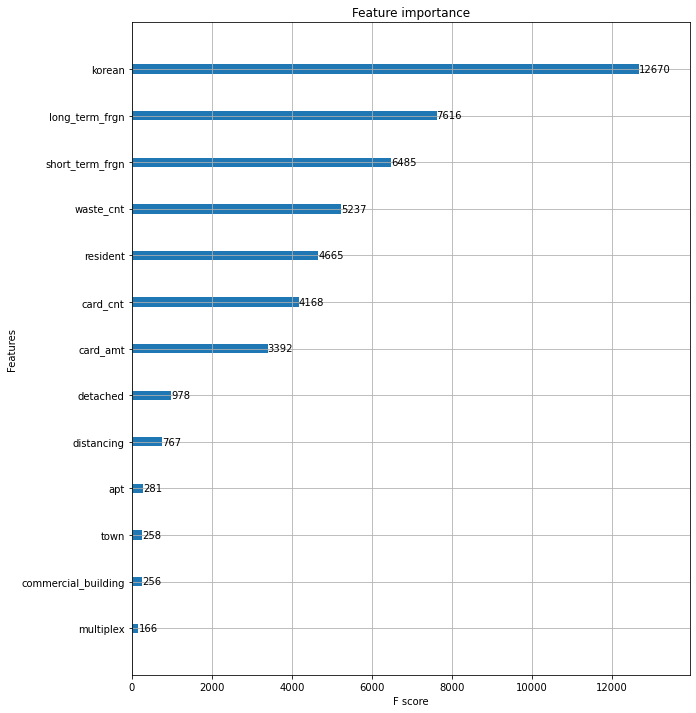

In [22]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)